# Table of Contents

1. [Single Run and Snapshot](#key1)<br>
    1.1 [Select Halos by Mass](#single1)<br>
    1.2 [Join Halos to Subhalos](#single2)
2. [Single Run and Multiple Snapshots](#key2)
3. [Multiple Runs and Single Snapshot](#key3)
4. [More Complex Examples...](#key4)<br>
    4.1. [Subitem1](#sub1)<br>
    4.2. [Subitem2](#sub2)

### This notebook gives examples of how to interact with the Indra halo database tables on the SciServer.

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import indratools as indra
import pandas as pd
import SciServer.CasJobs as cj

The halo and subhalo catalogs are stored in tables in the 'Indra' database context. There are two tables for each Indra run, from 2_0_0 to 7_7_7, containing FOF group or Subhalo information for every snapshot.

In [3]:
context = "Indra"
X = 2; Y = 3; Z = 4; snapnum = 58
tablename_fof = f'FOF_{X}{Y}{Z}'
tablename_sub = f'SubHalo_{X}{Y}{Z}'

Snapshot redshift and scalefactor information is also stored in a table in the Indra database. **NOTE TO SELF** 'redshift' and 'z' redundant: re-do table?

In [23]:
snaps = cj.executeQuery("select * from Snapshots order by redshift",context)
snaps.columns.values

array(['snapnum', 'redshift', 'time', 'z'], dtype=object)

In [16]:
snaps['z'][snaps['snapnum']==snapnum].values[0]

0.115883

In [ ]:
# Will probably want to say something about limitations of executeQuery (which I don't really know right now)
# and I THINK if submitJob is used instead, the query needs to put results into a temporary table in MyDB? Can't select directly with submitJob?
# e.g,    jobid=cj.submitJob(sql,context) where the sql text selects into MyDB.{table}
#         %time cj.waitForJob(jobid,verbose=True)
#         df=cj.executeQuery("select * from MyDB.{table}".format(table=tablename))    

There are two ways of executing SQL with the SciServer.CasJobs API: `executeQuery` and `submitJob`. **SEE DOCUMENTATION: ...**

Selecting a full halo catalog at a low-redshift snapshot requires too much memory for the `executeQuery` command. It is better to select only what you need, or if you want to use the entire catalog (FOF + Subhalo) of one snapshot of one Indra run, load the binary catalog with `cat = indra.getsubcat((X,Y,Z),snapnum)`.

Here is a quick way to find out the column names of both tables:

In [24]:
cj.executeQuery('select top 1 * from {} where snapnum = {}'.format(tablename_fof,snapnum),'Indra')

,fofId,firstSubhaloId,snapnum,np,numSubs,m_mean200,r_mean200,m_crit200,r_crit200,m_tophat,r_tophat,x,y,z,phKey,vx,vy,vz
0,580000000000,580000000000000,58,14300,7,114800.4,2.628052,94108.45,1.719383,106876.6,2.211089,2.87357,115.0327,111.9088,438,71.07629,-97.6995,151.4882


In [25]:
cj.executeQuery('select top 1 * from {} where snapnum = {}'.format(tablename_sub,snapnum),'Indra')

,subhaloId,fofId,snapnum,np,x,y,z,phKey,vx,vy,vz,vDisp,vMax,spinX,spinY,spinZ,mostBoundId,halfmassRadius
0,580000000000000,580000000000,58,14300,2.87357,115.0327,111.9088,438,71.07629,-97.6995,151.4882,1086.857,1639.329,54.71159,131.4823,141.8329,115474433,0.847541


Note that the masses are in units of 1e10 Msun/h (unlike the binary catalog), radii and positions in units of Mpc/h, and velocities in km/s. Note also that in the FOF tables, `np` refers to the number of particles in the main subhalo (e.g. FirstSubOfHalo given by firstSubhaloId) and not the parent FOF group.

# 1. Single Run and Snapshot
<a id="key1"></a>

## Select by mass
<a id="key2"></a>

Here we select halos above a given mass from a single run and snapshot. We define the minimum mass in the table's units of 1e10 Msun/h but return masses in units of Msun/h.

In [38]:
minmass = 10000.  # So minmass = 1e4 corresponds to 1e14 Msun/h.
sql = """select np, numSubs, m_crit200*1.0e10 as mass, r_crit200 as radius from {table}
    where snapnum = {snapnum} and m_crit200 > {minmass}
    order by mass desc
""".format(table=tablename_fof,snapnum=snapnum,minmass=minmass)
cj.executeQuery(sql,context)

,np,numSubs,mass,radius
0,34399,21,2.116298e+15,2.252916
1,35976,39,1.970758e+15,2.200039
2,29217,20,1.445832e+15,1.984169
3,27778,19,1.442457e+15,1.982453
4,23411,30,1.411521e+15,1.968359
...,...,...,...,...
11952,2084,3,1.000496e+14,0.814190
11953,2192,3,1.000496e+14,0.814388
11954,2179,3,1.000496e+14,0.814434
11955,2079,2,1.000496e+14,0.814302


## Select by mass and select subhalos
<a id="single2"></a>

Here we again select halos above a given mass from a given run and snapshot. We also return subhalos of these halos using SQL `inner join` and the positions of the subhalos. (Note that masses are only defined for FOF groups == main subhalos). We define a new column that keeps track of whether the halo is the main subhalo of the FOF group or not, using SQL `case when` syntax.

In [47]:
minmass = 10000.  # So minmass = 1e4 corresponds to 1e14 Msun/h.
sql = """select h.fofId, s.subhaloId, s.x, s.y, s.z, 
        case when h.firstSubhaloId = s.subhaloId then 1 else 0 end as isMain
    from {foftable} h inner join {subtable} s 
    on h.fofId = s.fofId
    and h.snapnum = {snapnum} and h.m_crit200 > {minmass}
""".format(foftable=tablename_fof,subtable=tablename_sub,snapnum=snapnum,minmass=minmass)
df = cj.executeQuery(sql,context)
df

,fofId,x,y,z,isMain
0,580570000010,306.6426,818.43890,204.1322,1
1,580570000010,308.6249,818.85180,202.9084,0
2,580570000010,308.0054,818.19580,203.1748,0
3,580570000010,309.0741,817.78510,203.2247,0
4,580570000012,281.5840,912.88260,239.9867,1
...,...,...,...,...,...
50627,581490000045,529.9363,72.74113,824.6356,0
50628,581500000029,565.1226,235.98780,766.3813,1
50629,581500000029,565.2031,235.97320,765.9363,0
50630,581500000029,563.8669,236.72810,766.2515,0


Let's plot them! We'll restrict the plot to a sub-volume of the full Gpc/h cube.

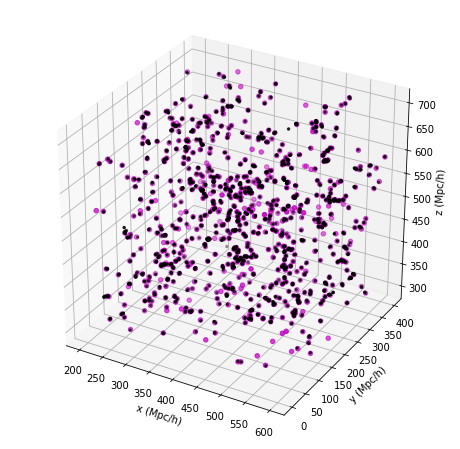

In [55]:
subdf = df[((df['x'] > 200) & (df['x'] < 600) & (df['y'] < 400) & (df['z'] > 300) & (df['z'] < 700))]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(subdf['x'][subdf['isMain']==0].values,subdf['y'][subdf['isMain']==0].values,subdf['z'][subdf['isMain']==0].values,marker='.',color='k')
ax.scatter(subdf['x'][subdf['isMain']==1].values,subdf['y'][subdf['isMain']==1].values,subdf['z'][subdf['isMain']==1].values,marker='o',color='m')
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)');

In [ ]:
# TO DO??
# I bet I could recover numSubs from the second df - select count(*) as numSubs group by fofId - and test this with the first df (which I didn't save...)
# ... but maybe it's not useful to do so....

# 2. Single Run and Multiple Snapshots
<a id="key2"></a>

In this example we'll select the most massive halo from each snapshot of a given run, while noting that the most massive halo won't necessarily be "the same" halo across snapshots.

Since this query can take some time, we will use `submitJob` instead of `executeQuery` and save the results to a new table in your personal `MyDB` database context. We first need to drop this table if it already exists, e.g. if you have run this example before and want to run it again.

In [68]:
# We create a table in your MyDB below: if you do have done this already, first drop the table
temptable = f'massive_{X}{Y}{Z}'
sql="""IF OBJECT_ID('{table}', 'U') IS NOT NULL 
  DROP TABLE {table}
""".format(table=temptable)
cj.executeQuery(sql,"MyDB")

,Rows Affected
0,0


Selecting the most massive halo in SQL uses the aggregate function `MAX` with the `GROUP BY` syntax to aggregate by `snapnum`. Then, selecting other columns that correspond to this maximum-mass halo row uses `join` on the results of the aggregating `select` clause. (If SQL is new to you, don't worry, I definitely googled how to do this.)

In [ ]:
sql = """select h.snapnum, h.np, h.numSubs, h.r_crit200 as radius, h.m_crit200*1.0e10 as mass,
        h.x, h.y, h.z
    into MyDB.{temptable}
    from {table} h join (select MAX(m_crit200) as mass, snapnum FROM {table} GROUP BY snapnum) max
        on h.m_crit200 = max.mass and h.snapnum = max.snapnum
""".format(table=tablename_fof,temptable=temptable)
jobid = cj.submitJob(sql,context)
cj.waitForJob(jobid)

In [93]:
df = cj.executeQuery('select * from MyDB.{} order by snapnum'.format(temptable))
df[:8]

,snapnum,np,numSubs,radius,mass,x,y,z
0,15,30,1,0.265511,1.757722e+12,236.3941,112.0773,781.6100
1,16,35,1,0.323328,2.460811e+12,236.5246,112.0514,781.6426
2,17,78,1,0.381431,3.585754e+12,236.7110,112.1097,781.7067
3,18,94,1,0.453455,6.046565e+12,236.9895,112.0399,781.6568
4,19,119,1,0.503971,8.366758e+12,237.0539,111.9012,781.6778
5,20,158,1,0.534648,9.983863e+12,237.3519,112.0080,781.6508
6,21,193,1,0.574975,1.237437e+13,237.3902,111.7825,781.6188
7,22,264,1,0.614943,1.504610e+13,436.3193,381.2192,248.3477


For fun let's plot the halo positions and color by their `snapnum`.

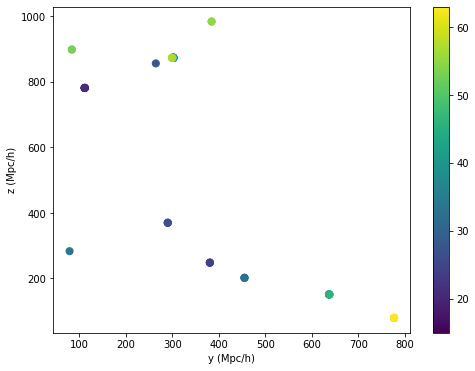

In [91]:
fig = plt.figure(figsize=(8,6))
plt.scatter(df['y'],df['z'],marker='o',s=50,c=df['snapnum'].values)
plt.colorbar()
plt.xlabel('y (Mpc/h)')
plt.ylabel('z (Mpc/h)');

# 3. Multiple Runs and Single Snapshot
<a id="key3"></a>

In [ ]:
# - select most massive halo from all runs for a given snapshot

# More Complex Thing (like lightcone?)
<a id="key4"></a>

In [ ]:
# Is the "SimulationDB" context open to all or limited to a group? That is where the Shape, Box, etc. functions are for spatial queries
# FOR THAT MATTER, is the "Indra" context currently open to all?